In [2]:
from google.colab import files

uploadedImage = files.upload()

Saving a66d7483cf351efcd2ec219e1ccf8299.jpg to a66d7483cf351efcd2ec219e1ccf8299 (3).jpg


In [3]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [4]:
# Read the image
img_BGR = cv2.imread('a66d7483cf351efcd2ec219e1ccf8299.jpg')

# Convert BGR to RGB
img_RGB = cv2.cvtColor(img_BGR, cv2.COLOR_BGR2RGB)

# Convert RGB to grayscale
img_Grayscale = cv2.cvtColor(img_BGR, cv2.COLOR_BGR2GRAY)

cv2.waitKey(0)
cv2.destroyAllWindows()

In [5]:
def median_filter(img_g, size):
  temp = []
  # Calculate the index for the center of the window
  indexer = size // 2
  # Create a window containing relative positions of neighboring pixels
  window = [
      (i, j)
      for i in range(-indexer, size - indexer)
      for j in range(-indexer, size - indexer)
  ]
   # Calculate the index for the median value in the sorted window
  index = len(window) // 2
  # Iterate over each pixel in the image
  for i in range(len(img_g)):
    for j in range(len(img_g[0])):
      img_g[i][j] = sorted(
        # Calculate the sorted values of neighboring pixels, considering edge cases
        0 if (min(i+a, j+b) < 0
          or len(img_g) <= i+a
          or len(img_g[0]) <= j+b
        ) else img_g[i+a][j+b]
        for a, b in window)[index]
  return img_g

In [6]:
# Apply median filter
img_Gray = cv2.cvtColor(img_BGR, cv2.COLOR_BGR2GRAY)
img_Median = median_filter(img_Gray, 7)

In [7]:
def conv2D(img, filter):
  # Pad image with one pixel of zeros on each side as a border to the input image to handle convolution at the image edges
  img = cv2.copyMakeBorder(img, 1, 1, 1, 1, cv2.BORDER_CONSTANT, value=0)

  # Create zeroed array of filtered image
  img_filtered = np.zeros((img.shape[0] - filter.shape[0] + 1, img.shape[1] - filter.shape[1] + 1))

  # Loop through each pixel and apply the filter
  for i in range(img.shape[0] - filter.shape[0] + 1):
    for j in range(img.shape[1] - filter.shape[1] + 1):
       # Take the sum of element-wise multiplication of the filter and the corresponding image region
      element = (np.sum(img[i : i + filter.shape[0], j : j + filter.shape[1]] * filter))

      # Threshold image to prevent clipping
      if element < 0:
        img_filtered[i][j] = 0
      elif element > 255:
        img_filtered[i][j] = 255
      else:
        img_filtered[i][j] = element

  return img_filtered

In [8]:
# Apply laplacian filter
laplacian_filter = np.array([[1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1], [1, 1, 1, -48, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1]])
img_Laplacian = np.abs(conv2D(img_Median, laplacian_filter))

In [9]:
# Apply binary threshold to invert image
img_Threshold = np.abs(conv2D(img_Median, laplacian_filter))
height, width = img_Threshold.shape
for y in range(height):
    for x in range(width):
        intensity = img_Threshold[y, x]
        if intensity >= 128:
            img_Threshold[y, x] = 0
        else:
            img_Threshold[y, x] = 255

In [10]:
def bilateral_filter(positional_strength, color_strength, size, img_RGB):
  # Get the shape of the matrix of image RGB
  img_filtered = np.zeros(img_RGB.shape)
  # Get the dimensions of the input RGB image (height, width, and channels)
  x, y, _ = img_RGB.shape
  margin = size // 2   # based on the specified filter size

  # Iterate over the pixels of the input RGB image, excluding the margin
  for i in range(margin, x - margin):
    for j in range(margin, y - margin):
      for k in range(3):

        # Calculate the central row and column
        center_row = size // 2
        center_col = size // 2

        # Initialize arrays to store Euclidean distances
        euclidean_distances = np.zeros((size, size), dtype = float)

        # Calculate Euclidean distance
        for row in range(size):
          for col in range(size):
            euclidean_distances[row, col] = np.sqrt((center_row - row) ** 2 + (center_col - col) ** 2)

        # Calculate absolute intensity difference
        img_portion = img_RGB[i - margin : i + margin + 1, j - margin : j + margin + 1, k]
        intensity_differences = abs(img_portion - img_RGB[i,j,k])

        # Calculate spatial filter BFs
        spatial_filter = np.exp(-euclidean_distances**2 / (2 * positional_strength**2))

        # Calculate range filter BFr
        range_filter = np.exp(-intensity_differences**2 / (2 * color_strength**2))

        # Get element wise multiplication of BFs and BFr
        element_wise = np.multiply(spatial_filter, range_filter)

        # Get summation of the elements of element_wise matrix
        weight = np.sum(element_wise)

        # Get reciprocal of the weight multiplied by each element of the element_wise matrix to get new matrix which is the bilateral filter
        result_BF = (1/weight) * element_wise

        # Apply 3D convolution
        element = 0
        conv_margin = len(result_BF) // 2
        element += np.sum(img_RGB[i - conv_margin : i + conv_margin + 1, j - conv_margin : j + conv_margin + 1, k] * result_BF)
        img_filtered[i, j, k] = abs(int(element))

  return img_filtered.astype(int)

In [11]:
# Apply multiple small bilateral filters for a strong cartoon effect
repetition_count = 1  # Number of times to apply bilateral filters to image
filter_size = 9  # Size of the bilateral filter (e.g., 9x9)
color_strength = 30  # Color strength of the bilateral filter
positional_strength = 5  # Positional strength of the bilateral filter

img_Bilateral = cv2.cvtColor(img_BGR, cv2.COLOR_BGR2RGB)

for r in range(repetition_count):
  img_Bilateral = bilateral_filter(positional_strength, color_strength, filter_size, img_Bilateral)

In [12]:
# Overlay the edge mask onto the bilateral filter
img_Cartoon = np.zeros_like(img_Bilateral)
for y in range(img_Threshold.shape[0]):
    for x in range(img_Threshold.shape[1]):
        # Check if the current pixel is an edge
        if img_Threshold[y, x] != 0:
            # Copy the pixel value from the painting image
            img_Cartoon[y, x] = img_Bilateral[y, x]

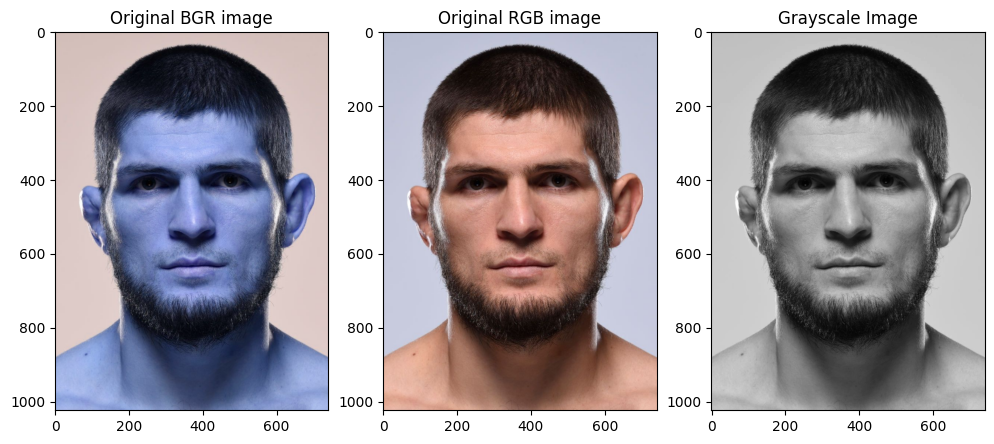

In [13]:
fig = plt.figure(figsize=(12, 6))

ax = fig.add_subplot(1,3,1)
ax.set_title(f"Original BGR image")
ax.imshow(img_BGR)

ax = fig.add_subplot(1,3,2)
ax.set_title(f"Original RGB image")
ax.imshow(img_RGB)

ax = fig.add_subplot(1,3,3)
ax.set_title(f"Grayscale Image")
ax.imshow(img_Grayscale, cmap = 'gray')
fig.show()

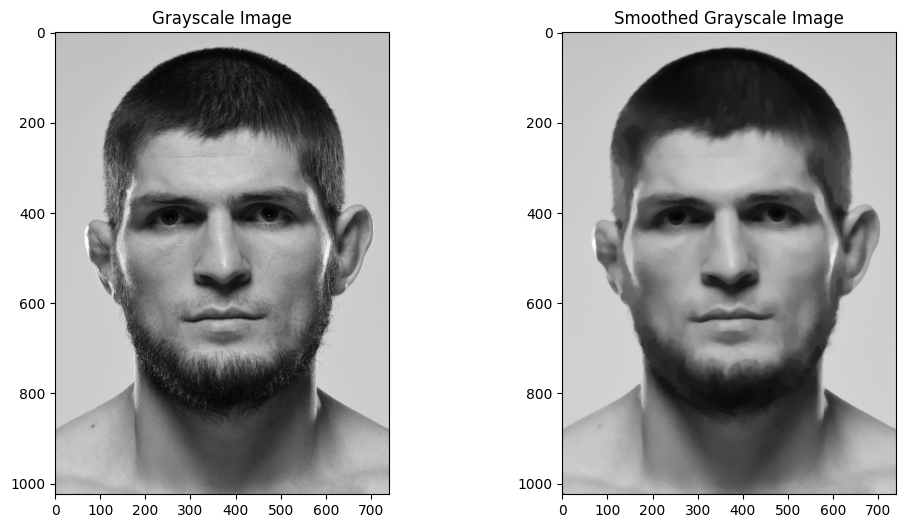

In [14]:
fig = plt.figure(figsize=(12, 6))

ax = fig.add_subplot(1,2,1)
ax.set_title(f"Grayscale Image")
ax.imshow(img_Grayscale, cmap = 'gray')

ax = fig.add_subplot(1,2,2)
ax.set_title(f"Smoothed Grayscale Image")
ax.imshow(img_Median, cmap = 'gray')
fig.show()

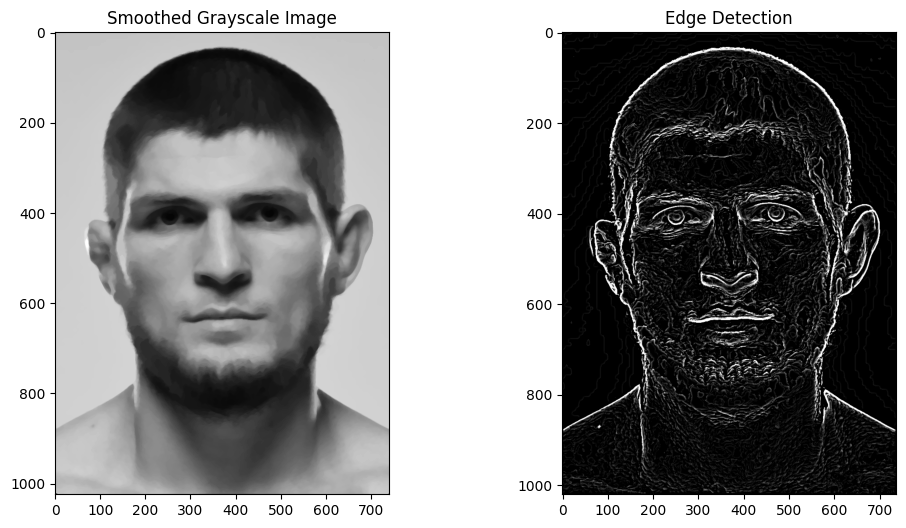

In [15]:
fig = plt.figure(figsize=(12, 6))

ax = fig.add_subplot(1,2,1)
ax.set_title(f"Smoothed Grayscale Image")
ax.imshow(img_Median, cmap = 'gray')

ax = fig.add_subplot(1,2,2)
ax.set_title(f"Edge Detection")
ax.imshow(img_Laplacian, cmap = 'gray')
fig.show()

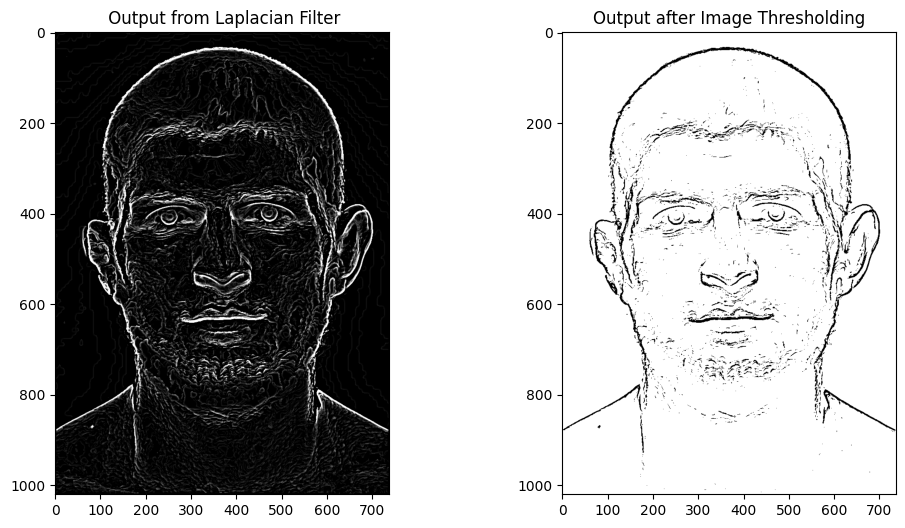

In [16]:
fig = plt.figure(figsize=(12, 6))

ax = fig.add_subplot(1,2,1)
ax.set_title(f" Output from Laplacian Filter")
ax.imshow(img_Laplacian, cmap = 'gray')

ax = fig.add_subplot(1,2,2)
ax.set_title(f"Output after Image Thresholding")
ax.imshow(img_Threshold, cmap = 'gray')
fig.show()

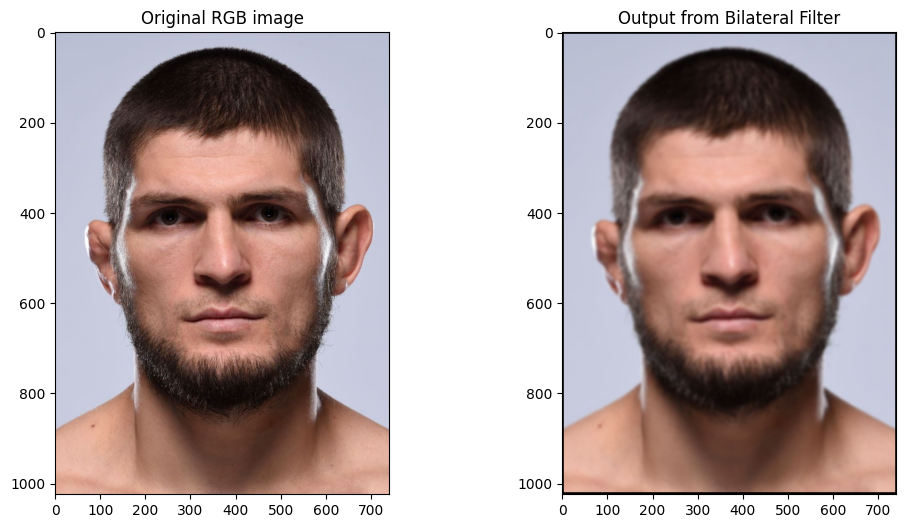

In [17]:
fig = plt.figure(figsize=(12, 6))

ax = fig.add_subplot(1,2,1)
ax.set_title(f"Original RGB image")
ax.imshow(img_RGB)

ax = fig.add_subplot(1,2,2)
ax.set_title(f"Output from Bilateral Filter")
ax.imshow(img_Bilateral)
fig.show()

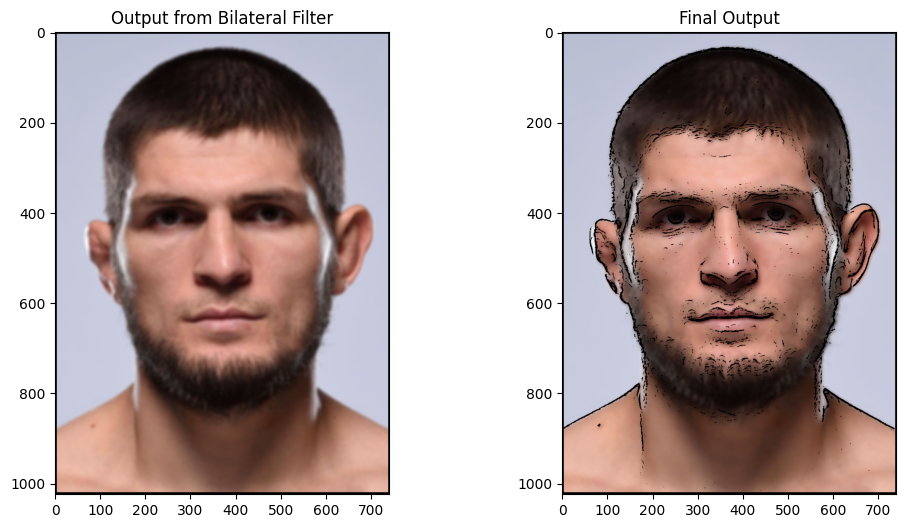

In [18]:
fig = plt.figure(figsize=(12, 6))

ax = fig.add_subplot(1,2,1)
ax.set_title(f"Output from Bilateral Filter")
ax.imshow(img_Bilateral)

ax = fig.add_subplot(1,2,2)
ax.set_title(f"Final Output")
ax.imshow(img_Cartoon)
fig.show()

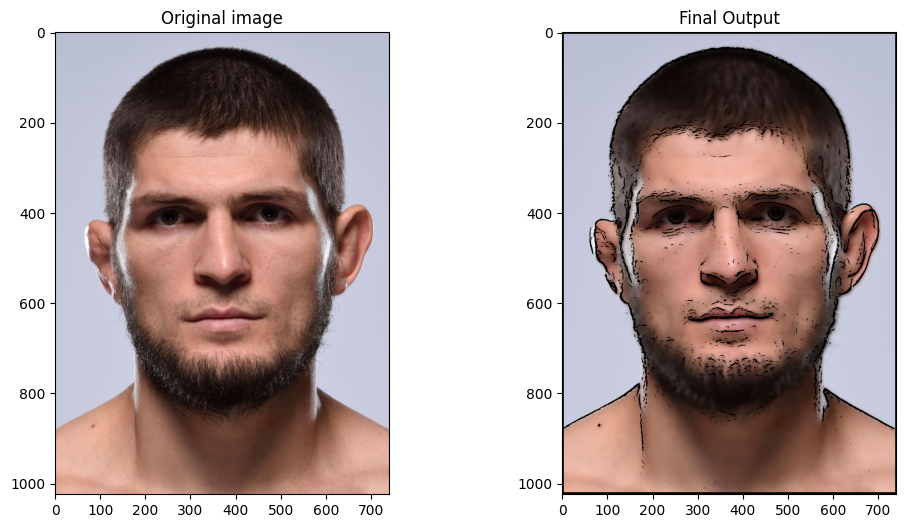

In [19]:
fig = plt.figure(figsize=(12, 6))

ax = fig.add_subplot(1,2,1)
ax.set_title(f"Original image")
ax.imshow(img_RGB)

ax = fig.add_subplot(1,2,2)
ax.set_title(f"Final Output")
ax.imshow(img_Cartoon)
fig.show()